# Classification of beats using an LSTM model and the holdout beats validation protocol

In [16]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
length = 277

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [23]:
!pip install --user protobuf == 3.20

ERROR: Invalid requirement: '='
Hint: = is not a valid operator. Did you mean == ?


### Extract task-specific data and one-hot encode labels

In [3]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train1 = X_train.reshape(-1, X_train.shape[1], 1)
X_test1 = X_test.reshape(-1, X_train.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

Loading  ../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Create a performance metrics function

In [4]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Build the LSTM architecture and train the model

In [5]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 256
activationFunction='relu'

def getlstmModel():
    
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train1.shape[1],X_train1.shape[2])))
    lstmmodel.add(LSTM(9, return_sequences=True))
    lstmmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(256, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()

lstmhistory= lstmmodel.fit(X_train1, y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)
lstmpredictions = lstmmodel.predict(X_test1, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 275, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 275, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 621)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               159232    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 279s 11ms/sample - loss: 0.6532 - accuracy: 0.7880 - val_loss: 0.2388 - val_accuracy: 0.9246
Epoch 2/10
25529/25529 [==============================] - 355s 14ms/sample - loss: 0.1887 - accuracy: 0.9409 - val_loss: 0.1444 - val_accuracy: 0.9535
Epoch 3/10
25529/25529 [==============================] - 365s 14ms/sample - loss: 0.1230 - accuracy: 0.9609 - val_loss: 0.1296 - val_accuracy: 0.9596
Epoch 4/10
25529/25529 [==============================] - 366s 14ms/sample - loss: 0.0909 - accuracy: 0.9705 - val_loss: 0.1095 - val_accuracy: 0.9652
Epoch 5/10
25529/25529 [==============================] - 159s 6ms/sample - loss: 0.0665 - accuracy: 0.9795 - val_loss: 0.0916 - val_accuracy: 0.9745
Epoch 6/10
25529/25529 [==============================] - 125s 5ms/sample - loss: 0.0591 - accuracy: 0.9812 - val_loss: 0.0932 - val_accuracy: 0.9756
Epoch 7/10
25529/25529 [==============================] - 127s 5ms/sample - loss: 0.0492 - accuracy: 0.9842

In [6]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(lstmmodel, 'lstmmodel_module2.h5')

### LSTM Loss vs Accuracy Plot

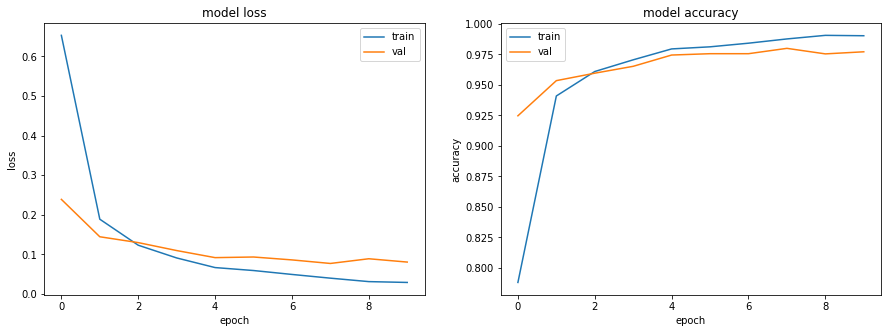

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(lstmhistory.history['loss'])
ax[0].plot(lstmhistory.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper right')
ax[1].plot(lstmhistory.history['accuracy'])
ax[1].plot(lstmhistory.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()
fig.savefig('lstm_holdout_beats_loss_and_accuracy.jpg')

### LSTM Performance Metrics

Accuracy  : 0.9450122811187703
Precision : 0.7684803350754088
Recall : 0.9563079267285125
f1score macro : 0.8267027442800912
f1score micro : 0.9450122811187703


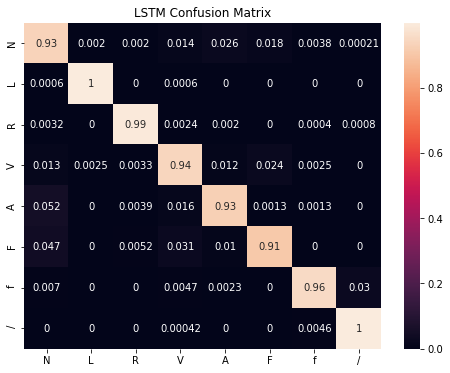

In [8]:
lstm_predict=np.argmax(lstmpredictions,axis=1)
lstm_actual_value=np.argmax(y_test1,axis=1)
lstm_results = showResults(lstm_actual_value, lstm_predict,'LSTM')
lstmmetrics = metrics.classification_report(lstm_actual_value, lstm_predict, digits=3)

categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
cm = confusion_matrix(lstm_actual_value, lstm_predict, normalize='true')
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('LSTM Confusion Matrix')
plt.show()
fig.savefig('lstm_holdout_beats_confusion_matrix_and_metrics_a.jpg', dpi = 400)

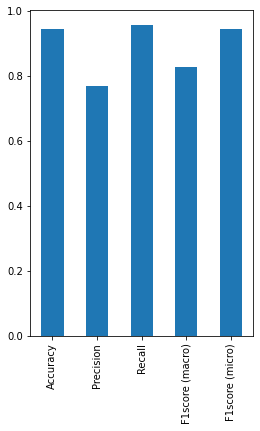

In [9]:
# performance metrics
LSTM_results = pd.DataFrame(data=lstm_results,index=('Model','Accuracy','Precision','Recall','F1score (macro)', 'F1score (micro)','CM'))
fig = plt.figure(figsize=(4,6))
LSTM_results[0][1:6].plot(kind='bar')
plt.show()
fig.tight_layout()
fig.savefig('lstm_holdout_beats_confusion_matrix_and_metrics_b.jpg', dpi = 400)

### Save LSTM model, model weights and results



In [12]:
# #serialize weights to HDF5
if not os.path.exists('./model_weights/'):
    os.mkdir('model_weights')
lstmmodel.save("./model_weights/lstmmodel_beats.h5")
print("Saved model to disk")

#Use only when running on all data
LSTM_results = pd.DataFrame(data=lstm_results,index=('Model','Accuracy','Precision','Recall','F1score (macro)', 'F1score (micro)','CM'))
print(LSTM_results)

if not os.path.exists('./model_results/'):
    os.mkdir('model_results')
LSTM_results.to_csv('./model_results/lstm_beats_results.csv', encoding='utf-8', index=False)

Saved model to disk
                                                                 0
Model                                                         LSTM
Accuracy                                                     0.945
Precision                                                    0.768
Recall                                                       0.956
F1score (macro)                                              0.827
F1score (micro)                                              0.945
CM               [[26820, 58, 58, 393, 753, 506, 109, 6], [1, 1...
